In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
import os
import glob
from nilearn import plotting, surface, datasets
from nilearn import image as nli


# Figure options
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
fm.findfont("Arial", rebuild_if_missing=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 7
plt.rcParams['pdf.fonttype'] = 42
opt_subtitle = { 'fontname':"Arial", 'fontweight':"bold", 'fontsize':11 }

fig_size_double = 19/2.54
fig_size_half   = 14/2.54
fig_size_single =  9/2.54
fig_size_min    =  3/2.54
dpi = 300

plt.style.use('default')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
col_learners = colors[6]
col_nonlearners = colors[9]
col_player1 = colors[0]
col_player2 = colors[1]
col_gray = '#666666'




behavior_df = pd.read_csv('behavior.csv')
behavior_df.set_index('subject', inplace=True)

rating_df = pd.read_csv('ratings.csv')
rating_df.set_index('subject', inplace=True)

voi_csv = 'params_modpsc_VOI'
brain_df = pd.read_csv(f'{voi_csv}_betas.csv')
voi_df = brain_df[ (brain_df['voi']=='Amy-BLA') ]
voi_df.set_index('subject', inplace=True)

/usr/local/lib/python3.8/dist-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


figure_2


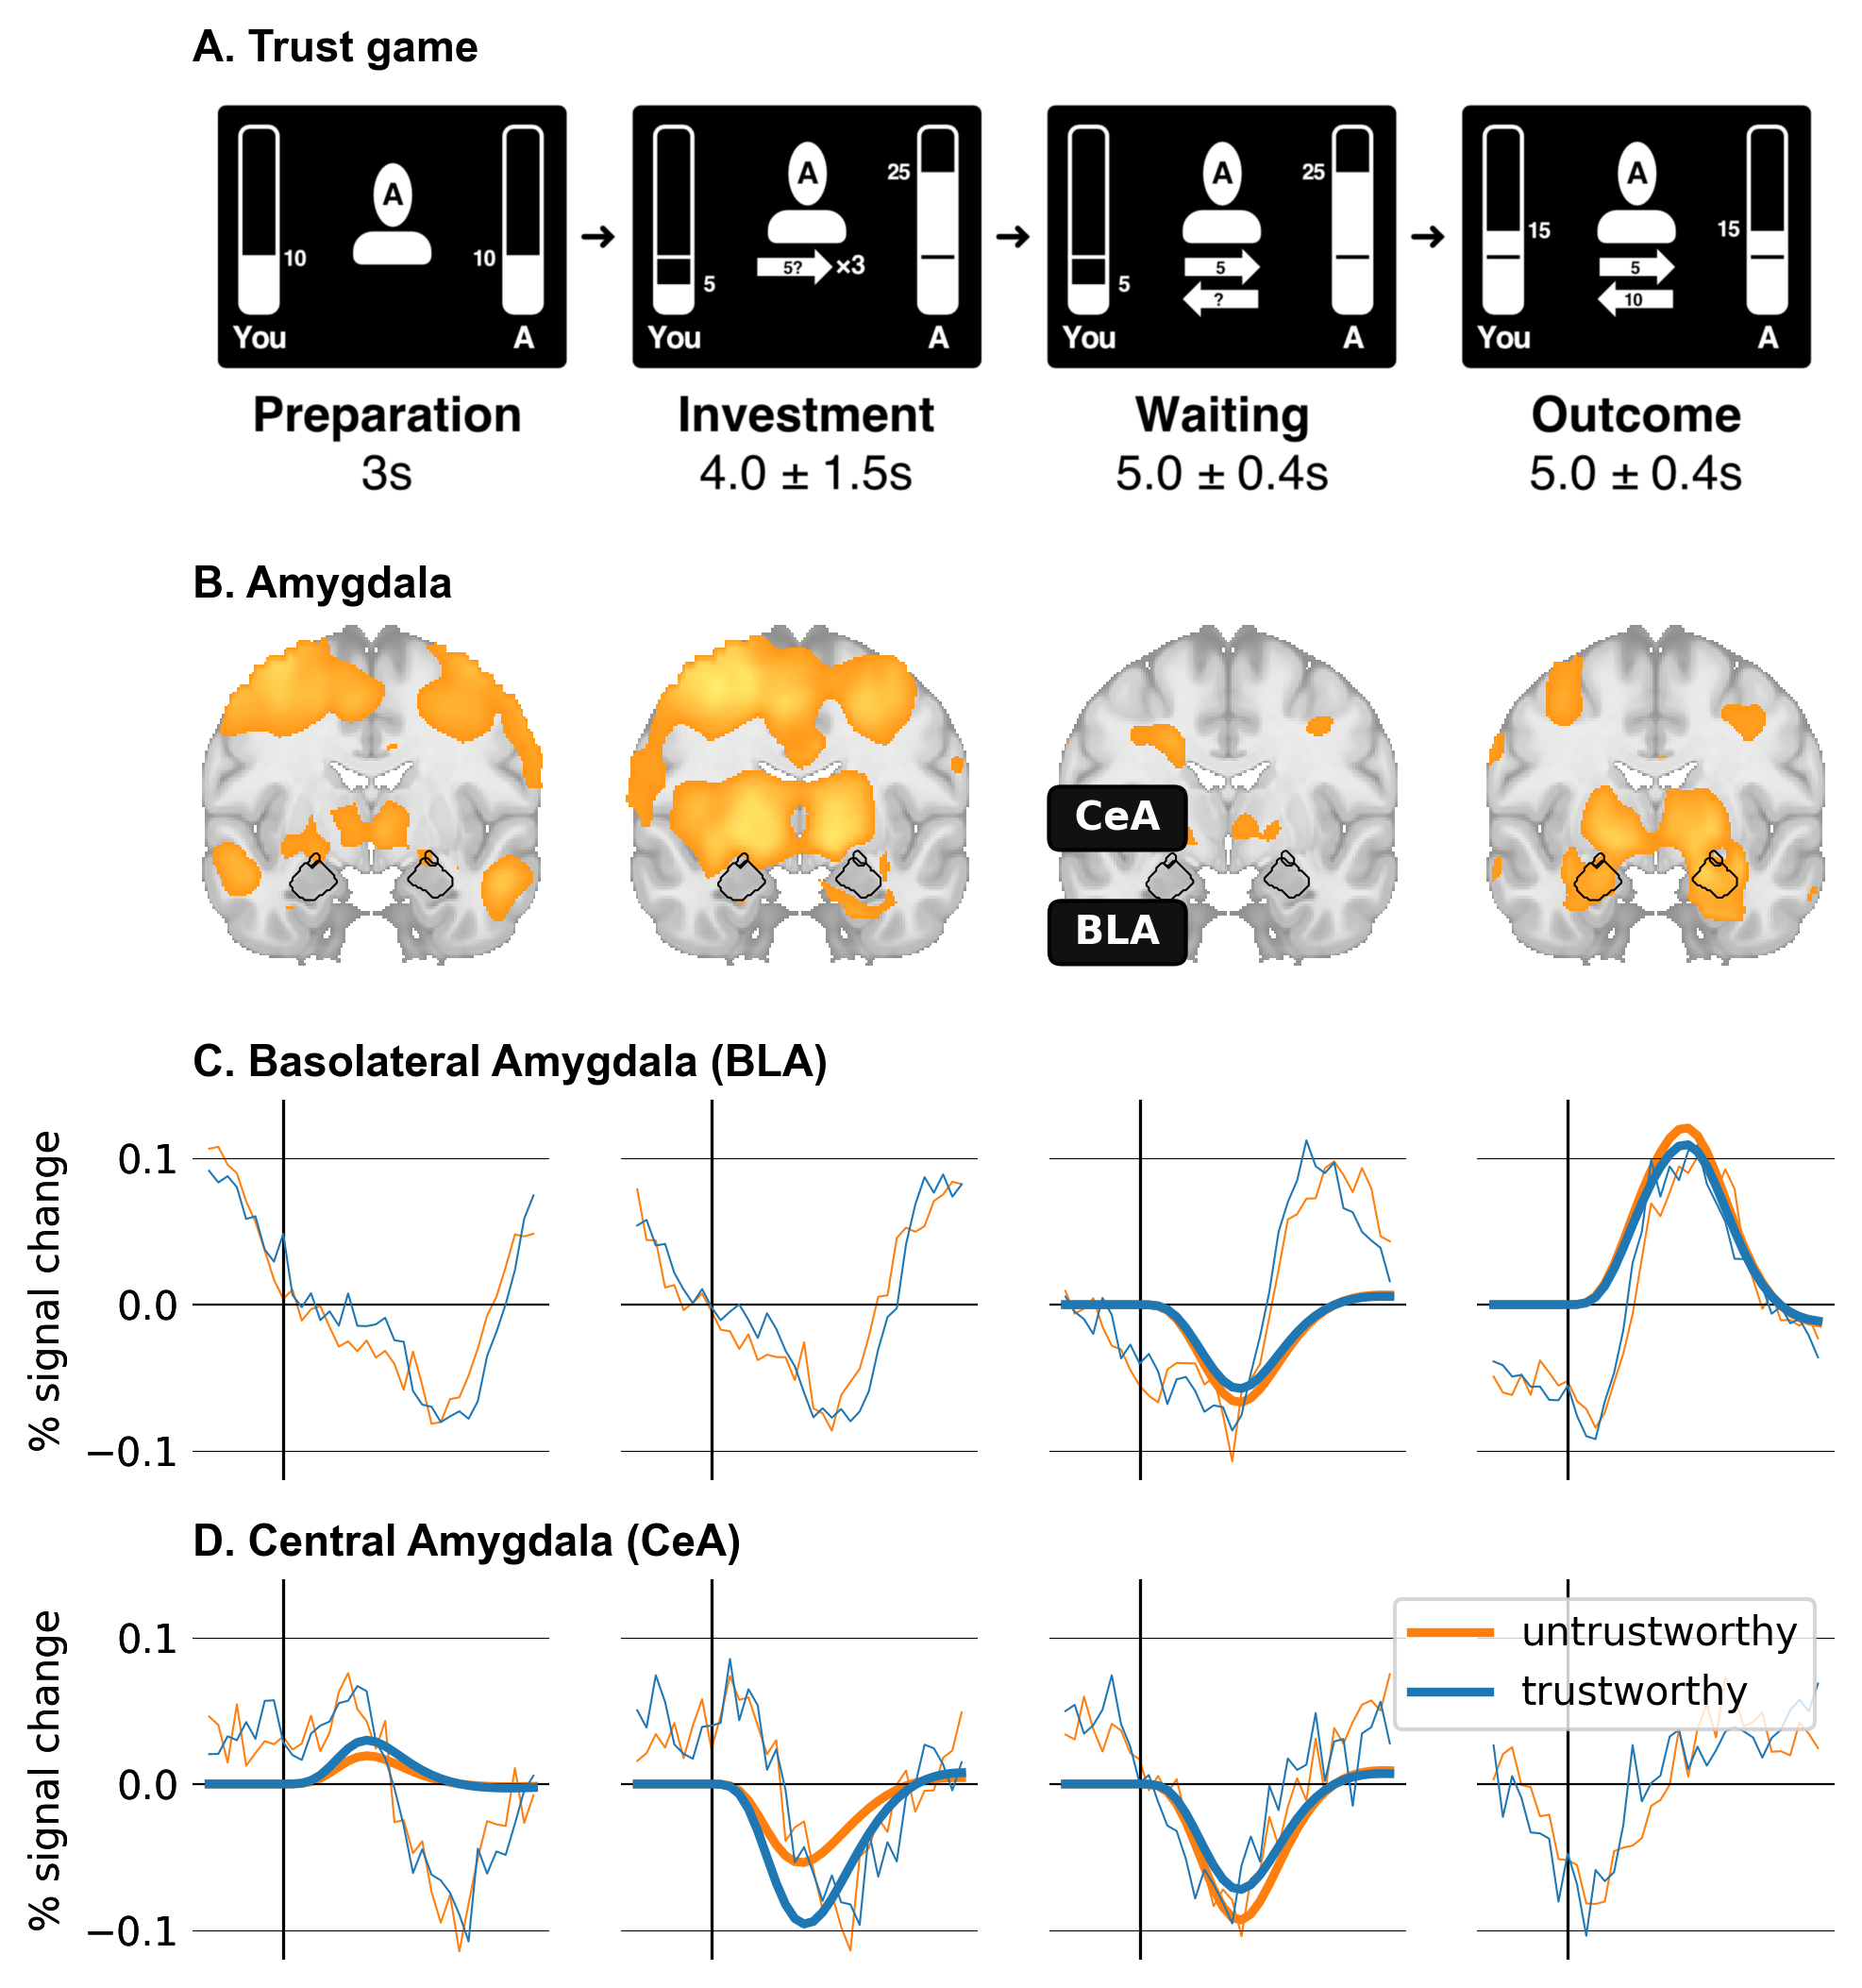

In [36]:
median_gain = np.median( behavior_df['gain'] )
median_diff_invest = np.median( behavior_df['diff_invest'] )
selector = behavior_df['diff_invest'] > median_diff_invest # good learners

betas_df = pd.read_csv('betas_df_outcomeblock.csv')
conditions = ['introduction', 'investment', 'waiting', 'outcome']


fig = plt.figure(figsize=[fig_size_double, fig_size_double*1.15], dpi=dpi)
gs = GridSpec(4, 4, figure=fig, height_ratios=[1.15, 1.0, 1, 1])


# Panel A

ax = fig.add_subplot(gs[0, :])
ax.axis('off')
ax.set_title('A. Trust game', loc='left', fontdict=opt_subtitle  )
img1 = plt.imread('Paradigm_bw.png')
ax.imshow(img1, interpolation="bicubic", aspect='auto')



# Panel B

nobrain = False

con_nii_list = glob.glob( f'spmT_[0-9][0-9][0-9][0-9].nii' ) 
con_nii_list = con_nii_list[0:4]


amygdala_BLA_mask = 'mask_amygdala_BLA_MNI.nii.gz'
amygdala_CEN_mask = 'mask_amygdala_CEN_MNI.nii.gz'
mni_template = 'mni_icbm152_t1_tal_nlin_sym_09a_skullstripped.nii'

con_names_list = ['Introduction', 'Investment', 'Waiting', 'Outcome']
    
ax = fig.add_subplot(gs[1, 0])
ax.set_title(f'B. Amygdala', loc='left', fontdict=opt_subtitle)
ax.set(frame_on=False)
ax.axis('off')

if not nobrain:
    for c, con_nii in enumerate(con_nii_list):
        ax = fig.add_subplot(gs[1,c])
        ax.set(frame_on=False)
        con_nii_thr = nli.math_img( '(img>0.0)*img', img=con_nii )
        cut=-6
        subfig = plotting.plot_stat_map(nli.math_img( 'img * (img>0.0)', img=con_nii_thr ), bg_img=nli.math_img( 'img * (img>35)', img=mni_template ), threshold=3.22, vmax=36, display_mode='y', figure=fig, axes=ax, 
                                        black_bg=False, annotate=False, colorbar=False, cut_coords = [cut], cmap='afmhot' )
        subfig.add_contours(amygdala_BLA_mask, levels=[.0], colors='#000000', linewidths=0.5)
        subfig.add_contours(amygdala_CEN_mask, levels=[.0], colors='#000000', linewidths=0.5)
        
        if c==2:
            bboxstyle = dict(boxstyle='round', pad=0.3, edgecolor='#000000', facecolor='#111111', alpha=1.0, linewidth=1)
            ax.text(0.35, 0.45, ' CeA ', horizontalalignment='right', color='white', fontweight='bold', bbox=bboxstyle)
            ax.text(0.35, 0.15, ' BLA ', horizontalalignment='right', color='white', fontweight='bold', bbox=bboxstyle)
            

            
# Panels C, D

titles = ['C. Basolateral Amygdala (BLA)', 'D. Central Amygdala (CeA)']
twin = np.arange(-8, 28)

for row, voi in enumerate(['Amy-BLA','Amy-CEN']):
    df = pd.read_csv(f'{voi_csv}_{voi}.csv')
    
    ax = fig.add_subplot(gs[2+row,0])
    ax.axis('off')
    ax.set_title(f'{titles[row]}', loc='left', fontdict=opt_subtitle)
    
    mean_plots = []
    
    for c, condition in enumerate( conditions ):
        trials = [3,20]
        for player in [2,1]:
            sel = ( df['condition']=='%s_%d' % (condition, player) ) & ( df['trial'].isin(range(trials[0],trials[1])) ) #& ( df['subject'].isin( [ subjects[s] for s in range(9,16)] ) )
            bs = betas_df[ betas_df['VOI']==voi ].loc[:,f'{condition}_{player}']                 

            y = df[sel][[ 'y_t%+d' % t for t in twin ]].values
            y_mean = np.mean( y, axis=0 )
            y_mean = y_mean - np.mean(y_mean)
            y_err = np.std( y, axis=0 ) / np.sqrt(y.shape[0])
            n_subjects = y.shape[1]

            X_mean = np.mean( df[sel][[ 'X_t%+d' % t for t in twin ]].values, axis=0 ) 
            X_mean = X_mean * np.mean( bs ) # HRF response based on individual trials

            ax = fig.add_subplot(gs[2+row,c])
            ax.set(frame_on=False)
            if row >= 2:
                ax.set(xlabel='Seconds')
            else:
                ax.xaxis.set_ticklabels([])
                ax.set_xticks([])
            if c==0:
                ax.set(ylabel='% signal change' ) 
            else:
                ax.yaxis.set_ticklabels([])

            ax.tick_params('y', length=0, width=0)
            ax.axhline(y=0, linewidth=0.5, color='k')
            ax.axvline(x=0, linewidth=0.75, color='k')  
            ax.yaxis.grid(color='k', ls = '-', lw = 0.25)

            
            bs = betas_df[ betas_df['VOI']==voi ].loc[:, [f'{condition}_1', f'{condition}_2']]    
            bs = np.mean(bs,axis=1)
            statres = stats.ttest_1samp(bs, popmean=0.0)
            caption = r'%s %s %d, T=%0.1f, $p=%.4f$' % (voi, condition, player, statres.statistic, statres.pvalue ) 
            if statres.pvalue < 0.05/(len(titles)*len(conditions)*2): 
                lw = 2.25
            else:
                lw = 0.00


            if player==1:
                style_model = {'color':col_player1}
                style_data = {'fillstyle': 'none', 'color':col_player1}                
            else:
                style_model = {'color':col_player2}
                style_data = {'fillstyle': 'none', 'color':col_player2}

            hndl, = plt.plot(twin, X_mean, linewidth=lw, alpha=1, **style_model, label=['trustworthy','untrustworthy'][player-1])
            mean_plots.append(hndl)
            ax.plot( twin, y_mean, linewidth=0.5, markevery=1, alpha=1, label=f'P{player}, {caption}', **style_data )
            ax.set_ylim((-0.12, 0.14))
    if row==1:
        ax.legend( handles=mean_plots[4:6], frameon=True )              
            
            

        
plt.subplots_adjust(hspace=0.25)

fig_output_file = 'figure-2'
print(fig_output_file)
fig.savefig(f'{fig_output_file}.png', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w') 
fig.savefig(f'{fig_output_file}.pdf', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w')    

In [57]:
# p1 trustworthy (blue)
# p2 untrustworthy (orange)

thresh = 0.05/(len(titles)*len(conditions)*2)

print('# Trustworthy and untrustworthy player')
for voi in ['Amy-BLA', 'Amy-CEN']:
    for c, condition in enumerate( conditions ):
        bs = 0.5 * ( betas_df[ betas_df['VOI']==voi ].loc[:,f'{condition}_1'].values + betas_df[ betas_df['VOI']==voi ].loc[:,f'{condition}_2'].values )
        statres = stats.ttest_1samp(bs, popmean=0.0)
        d = np.abs( np.mean(bs)/np.std(bs) )
        ci = np.abs( 1.96 *  np.std(bs) / np.sqrt(len(bs)) )
        caption = "%s %12s %16s:    %+0.2f±%0.2f, t%d=%0.1f, p=%.4f, d=%0.1f" % (('* ' if statres.pvalue<thresh else '  '), voi, condition, np.mean(bs), ci, len(bs)-1, np.abs(statres.statistic), statres.pvalue, d ) 
        print(caption)            
    print()
    
print('# Trustworthy vs. untrustworthy player')
for voi in ['Amy-BLA', 'Amy-CEN']:
    for c, condition in enumerate( conditions ):         
        bs = ( betas_df[ betas_df['VOI']==voi ].loc[:,f'{condition}_1'].values - betas_df[ betas_df['VOI']==voi ].loc[:,f'{condition}_2'].values )
        statres = stats.ttest_1samp(bs, popmean=0.0)
        d = np.abs( np.mean(bs)/np.std(bs) )
        ci = np.abs( 1.96 *  np.std(bs) / np.sqrt(len(bs)) )
        caption = "%s %12s %16s:    %+0.2f±%0.2f, t%d=%0.1f, p=%.4f, d=%0.1f" % (('* ' if statres.pvalue<thresh else '  '), voi, condition, np.mean(bs), ci, len(bs)-1, np.abs(statres.statistic), statres.pvalue, d ) 
        print(caption)  
    print()

# Trustworthy and untrustworthy player
        Amy-BLA     introduction:    -0.00±0.03, t61=0.2, p=0.8530, d=0.0
        Amy-BLA       investment:    -0.04±0.04, t61=2.2, p=0.0293, d=0.3
*       Amy-BLA          waiting:    -0.07±0.03, t61=5.2, p=0.0000, d=0.7
*       Amy-BLA          outcome:    +0.11±0.02, t61=9.8, p=0.0000, d=1.3

*       Amy-CEN     introduction:    +0.04±0.02, t61=3.2, p=0.0021, d=0.4
*       Amy-CEN       investment:    -0.12±0.03, t61=6.6, p=0.0000, d=0.8
*       Amy-CEN          waiting:    -0.10±0.03, t61=6.8, p=0.0000, d=0.9
        Amy-CEN          outcome:    -0.01±0.02, t61=1.1, p=0.2972, d=0.1

# Trustworthy vs. untrustworthy player
        Amy-BLA     introduction:    +0.03±0.03, t61=2.1, p=0.0369, d=0.3
        Amy-BLA       investment:    -0.06±0.05, t61=2.3, p=0.0259, d=0.3
        Amy-BLA          waiting:    +0.01±0.02, t61=1.0, p=0.3426, d=0.1
        Amy-BLA          outcome:    -0.01±0.02, t61=0.9, p=0.3470, d=0.1

        Amy-CEN     introductio